# Demo: Knowing the roads in a city with radroads
## Yuwen Chang 2018/04/01

## About this notebook

This notebook demonstrates the usage of [radroads.py](https://github.com/argo-marketplace/RadRoads/blob/master/notebooks/radroads.py)

## About radroad.py

The functions in the python script will allow user to query basic road stats in a given city or area as long as boundary and road network data is available on OpenStreetMap. The output includes:
1. shortest
2. longest
3. straightest
4. curviest

Currently, there are still various improvements to be done. Some limitations worth mentioning first are:
1. Roads are group by names, which may lead to some inconsistency of what we would call a continuous road.
2. Roads with multiple (more than 2) or problematic terminal node counts are ignored for sinuosity calculation. The reason is the difficulty to identify which are the beginning and end used to calculate this metric.
3. Despite that exclusion, the measurement of sinuosity can still be inaccurate due to how terminal nodes are defined and extracted for now.
4. Results are not filtered; therefore, you may see the shortest or the straightest road being a 5-meter drive way.

Also notice that querying a big city can take a lot of time to download the data.

# Packages

In [1]:
import numpy as np
import pandas as pd
import pylab as pl

import osmnx as ox
import networkx as nx
import geopandas as gpd
from collections import Counter

from geopy import Nominatim
from geopy.distance import vincenty
from shapely.geometry import Point

%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Demo

In [2]:
# import the functions
import radroads as rr

In [3]:
# simply downloading the data
rr.GetRoads("Brooklyn, NY")

Existing local data of Brooklyn, NY is loaded as shapefiles



(               highway       osmid ref                               geometry
 0                         42460102               POINT (-73.890404 40.643689)
 1                         42460105       POINT (-73.88827000000001 40.645062)
 2                         42460121               POINT (-73.903589 40.635803)
 3                         42460123               POINT (-73.902781 40.635077)
 4                         42460126               POINT (-73.902466 40.634792)
 5                         42460129               POINT (-73.902293 40.634638)
 6                         42460142               POINT (-73.901979 40.634356)
 7                         42460148               POINT (-73.900161 40.632724)
 8                         42460151               POINT (-73.898349 40.631094)
 9                         42460153             POINT (-73.8965489 40.6294546)
 10     traffic_signals    42460162               POINT (-73.920581 40.650707)
 11                        42460165                P

Existing local data of Brooklyn, NY is loaded as shapefiles

Shortest road: Via Vespucci (10.43 meters)

                                     name     length  \
1468                         Via Vespucci  10.428215   
471                      Crescent Terrace  12.902141   
1688  ['Seaview Avenue', 'Gateway Drive']  13.387973   
939                       Lawrence Street  18.450232   
250                         Bay 37 Street  19.462921   

                              highway oneway  
1468                      residential  False  
471                       residential  False  
1688  ['residential', 'unclassified']   True  
939                       residential  False  
250                       residential  False   

Longest road: Belt Parkway (52801.63 meters)

                  name        length    highway oneway
290       Belt Parkway  52801.628331   motorway   True
955   Linden Boulevard  26566.636420    primary  False
1128     Ocean Parkway  25337.692258  secondary   True
917     

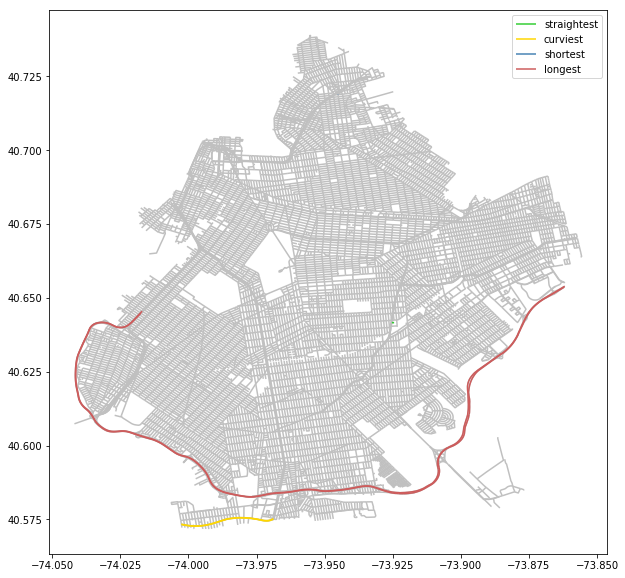

In [3]:
# extract road stats from data
# download if data is not previously downloaded
rr.RadRoads("Brooklyn, NY")

Data of Manhattan, NY is downloaded, saved, and loaded as shapefiles

Shortest road: Baruch Place (13.80 meters)

                       name     length      highway oneway
47             Baruch Place  13.799641  residential   True
467  South Pinehurst Avenue  27.562684  residential  False
12                3rd Place  32.637134  residential  False
447    Riverside Drive West  33.824470    secondary  False
489     Third Avenue Bridge  47.951719      primary   True 

Longest road: FDR Drive (31579.77 meters)

                     name        length      highway oneway
274             FDR Drive  31579.769061     motorway   True
67               Broadway  29703.131703      primary   True
415           Park Avenue  16821.363440    secondary   True
446       Riverside Drive  15816.997901  residential   True
324  Henry Hudson Parkway  15364.649281     motorway   True 

Straightest road: Bethune Street
road dist.: 281.07
shortest dist.: 281.79
sinuosity: 0.99746

       distance      length   

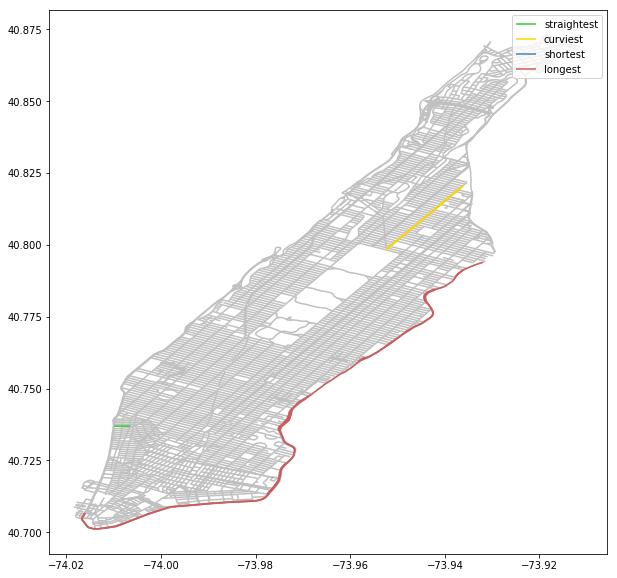

In [4]:
rr.RadRoads("Manhattan, NY")

Existing local data of Shorewood Hills, WI is loaded as shapefiles

Shortest road: Highland Avenue (8.03 meters)

                               name     length      highway oneway
17                  Highland Avenue   8.034172  residential   True
40                       Wood Close  17.018351  residential  False
2                      Beloit Court  55.709240  residential  False
46  ['Yale Road', 'Amherst Street']  78.378650  residential  False
27                       Shady Lane  78.536814  residential  False 

Longest road: University Avenue (1425.87 meters)

                    name       length      highway oneway
35     University Avenue  1425.870863      primary   True
36  University Bay Drive  1129.604961  residential  False
12        Edgehill Drive   914.653937  residential  False
33         Tally Ho Lane   839.309582  residential  False
28   Shorewood Boulevard   820.192567  residential  False 

Straightest road: Wood Close
road dist.: 17.02
shortest dist.: 17.04
sinuosity: 0.

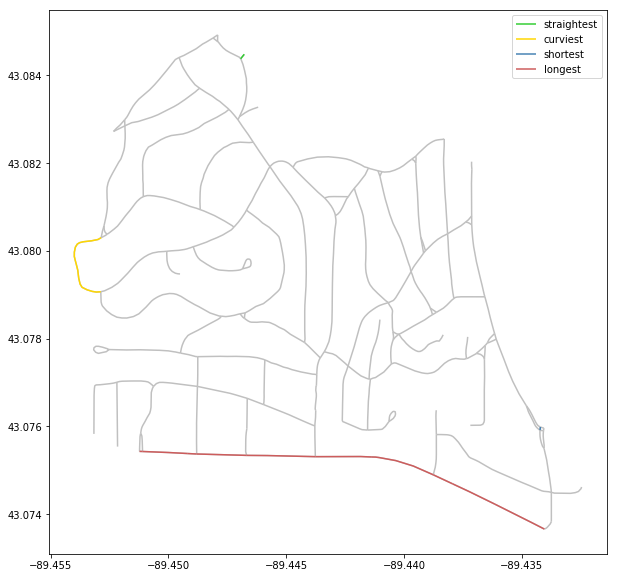

In [5]:
rr.RadRoads("Shorewood Hills, WI")

# Function for OSM data download

In [18]:
def GetRoads(city, ntype='drive'):
    """
    Load road network data (shapefile) locally. If not available,
    download the data through OpenStreetMap Nominatim API first.
    
    Parameters
    ----------
    city : string
        The name of the city (or place) of interest.
    ntype : string
        The type of street network to get.
        {'walk', 'bike', 'drive', 'drive_service', 'all', 'all_private'} 
    Returns
    -------
    G_nodes : geopandas.geodataframe.GeoDataFrame
        The GeoDataFrame of the nodes of city road network.
    G_edges : geopandas.geodataframe.GeoDataFrame
        The GeoDataFrame of the edges of city road network.
    Notes
    -----
    If data download is unsuccessful, check query results on
    the Nominatim web page and see if available results exist.
    """
    
    # load road network from local data
    try:
        G_nodes = gpd.read_file("data/" + city + "/nodes/nodes.shp")
        G_edges = gpd.read_file("data/" + city + "/edges/edges.shp")
        print("Existing local data of " + city + " is loaded as shapefiles\n")

    # download from OpenStreetMap if local data is not available
    except:
        # try different query results
        n = 1
        while n <= 5:
            try:
                G = ox.graph_from_place(query=city, network_type=ntype, which_result=n)
                break
            except ValueError:
                n += 1
        ox.save_graph_shapefile(G, filename=city, folder=None, encoding='utf-8')
        G_nodes = gpd.read_file("data/" + city + "/nodes/nodes.shp")
        G_edges = gpd.read_file("data/" + city + "/edges/edges.shp")
        print("Data of " + city + " is downloaded, saved, and loaded as shapefiles\n")
    return(G_nodes, G_edges);

# Function for querying basic statistics of a given road network

In [71]:
def RadRoads(city, ntype='drive', limit=5):
    """
    In a given city (or geographical area) in OSM:
    find the straightest and curviest roads by name;
    find the shortest and longest roads by name.
    
    Parameters
    ----------
    city : string
        The name of the city (or place) of interest.
    ntype : string
        The type of street network to get.
        {'walk', 'bike', 'drive', 'drive_service', 'all', 'all_private'}
    limit : integer
        Number of top records to be listed in each category.
    Returns
    -------
    1. name and length of the shortest roads
        and a dataframe of a top list
    2. name and length of the longest roads
        and a dataframe of a top list
    3. name and sinuosity info of the straightest road
        and a dataframe of a top list
    4. name and sinuosity info of the curviest road
        and a dataframe of a top list
    5. network graph plot of the given city
        with top roads marked with colors
    """

    # load data
    # load road network from local data
    try:
        G_nodes = gpd.read_file("data/" + city + "/nodes/nodes.shp")
        G_edges = gpd.read_file("data/" + city + "/edges/edges.shp")
        print("Existing local data of " + city + " is loaded as shapefiles\n")

    # download from OpenStreetMap if local data is not available
    except:
        # try different query results
        n = 1
        while n <= 5:
            try:
                G = ox.graph_from_place(query=city, network_type=ntype, which_result=n)
                break
            except ValueError:
                n += 1
        ox.save_graph_shapefile(G, filename=city, folder=None, encoding='utf-8')
        G_nodes = gpd.read_file("data/" + city + "/nodes/nodes.shp")
        G_edges = gpd.read_file("data/" + city + "/edges/edges.shp")
        print("Data of " + city + " is downloaded, saved, and loaded as shapefiles\n")

    ##################################################################
    # NOTICE: 'length' specified with method call may cause problems #
    ##################################################################

    # combine road segments and aggregate the total lengths
    G_edges['length'] = G_edges['length'].astype('float')
    dict_v = {'length': 'sum', 'highway': 'first', 'oneway': 'first'}
    table = G_edges.groupby('name').agg(dict_v).reset_index()
    
    # remove messy segments w/o names
    table = table[table['name'] != '']
    table.dropna(how='any', inplace=True)

    ### LENGTH ###
    
    # calculate shortest and longest roads
    short = table.sort_values(by='length', ascending=True).head(limit)
    long = table.sort_values(by='length', ascending=False).head(limit)

    # extract road names
    roads = list(G_edges['name'].unique())
    roads.remove('') ### remove messy segements without names ###
    rnames = []
    dist_d = []
    dist_l = []
    sinuosity = []

    ### SINUOSITY ###
    
    # calculate sinuosity for each road
    # create a dataframe containing all the segments of a road for each road
    for i, r in enumerate(roads):
        df_road = G_edges[G_edges['name'] == roads[i]]
        # list all the nodes
        road_nodes = list(df_road['from'].values) + list(df_road['to'].values)
        # count all the nodes
        tdict = dict(Counter(road_nodes))
        tdf = pd.DataFrame(list(tdict.items()), columns=['node', 'count'])
        # select nodes that only occur once (terminals of a road)
        tdf_sub = tdf[tdf['count']==1]

        if len(tdf_sub) != 2:

            continue ### skip roads with more than two terminal nodes for now ###

        else:
            # extract coordinates of the two terminal nodes from the city nodes graph
            G_nodes_term = G_nodes[list(map(lambda n: n in list(tdf_sub['node'].values), list(G_nodes['osmid'])))]
            coord1 = list(G_nodes_term.iloc[0,:]['geometry'].coords)[0]
            coord2 = list(G_nodes_term.iloc[1,:]['geometry'].coords)[0]
            p1 = coord1[1], coord1[0]
            p2 = coord2[1], coord2[0]

            # calculate shortest Distance between two nodes
            d_d = vincenty(p1, p2).meters
            # calculate actual route Length
            d_l = df_road['length'].astype('float', error='coerce').sum()
            # calculate sinuosity
            sinu = d_l / d_d

            # append all values to lists
            rnames.append(r) # road name
            dist_d.append(d_d) # shortest Distance
            dist_l.append(d_l) # actual Length
            sinuosity.append(sinu) #sinuosity

    # create a dataframe with sinuosity data
    df_sinu = pd.DataFrame({'name': rnames,
                            'distance': dist_d,
                            'length': dist_l,
                            'sinuosity': sinuosity})

    # calculate straightest and curviest roads
    straight = df_sinu.sort_values('sinuosity', ascending=True).head(limit)
    curve = df_sinu.sort_values('sinuosity', ascending=False).head(limit)

    straight_0 = straight.iloc[0]
    curve_0 = curve.iloc[0]

    # print out output
    print('Shortest road: {:s} ({:.2f} meters)\n'.format(short.iloc[0]['name'], short.iloc[0]['length']))
    print(short,"\n")
    print('Longest road: {:s} ({:.2f} meters)\n'.format(long.iloc[0]['name'], long.iloc[0]['length']))
    print(long,"\n")
    print('Straightest road: {:s}\nroad dist.: {:.2f}\nshortest dist.: {:.2f}\nsinuosity: {:.5f}\n'.format(
        straight.iloc[0]['name'], straight.iloc[0]['length'], straight.iloc[0]['distance'], straight.iloc[0]['sinuosity']))
    print(straight,"\n")
    print('Curviest road: {:s}\nroad dist.: {:.2f}\nshortest dist.: {:.2f}\nsinuosity: {:.5f}\n'.format(
        curve.iloc[0]['name'], curve.iloc[0]['length'], curve.iloc[0]['distance'], curve.iloc[0]['sinuosity']))
    print(curve,"\n")

    # plot the graph of the area
    fig, ax = pl.subplots(figsize=(10,10))
    G_edges.plot(color='silver', ax=ax)

    G_edges[G_edges['name'] == straight.iloc[0]['name']].plot(color='limegreen', ax=ax, label='straightest')
    G_edges[G_edges['name'] == curve.iloc[0]['name']].plot(color='gold', ax=ax, label='curviest')
    G_edges[G_edges['name'] == short.iloc[0]['name']].plot(color='steelblue', ax=ax, label='shortest')
    G_edges[G_edges['name'] == long.iloc[0]['name']].plot(color='indianred', ax=ax, label='longest')

    pl.legend(fontsize='medium')
    pl.show()

# Unmerged part

## > > > > > FUTURE: group by osmid instead of road name < < < < <
## annotate road names on the plot

In [ ]:
#table[table.length > 100].sort_values(by='length', ascending=True).head(limit)

short_0 = short.iloc[0]
long_0 = long.iloc[0]

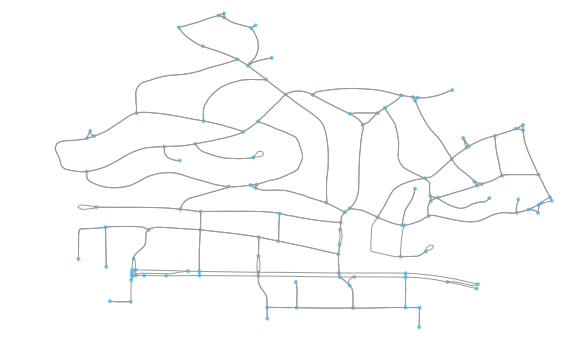

(<matplotlib.figure.Figure at 0x112e867f0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1139a1128>)

In [4]:
# import a small area as sandbox
G = ox.graph_from_address('Shorewood Hills, WI', distance=1000,
                          distance_type='network', network_type='drive')
ox.plot_graph(G)

In [ ]:
import os
import gmaps
import gmaps.datasets
gmaps.configure(api_key=os.getenv("GOOGLEAPIKEY"))

In [ ]:
locations = gmaps.datasets.load_dataset("taxi_rides")

In [ ]:
fig = gmaps.figure()
fig.add_layer(gmaps.heatmap_layer(locations))
fig

In [ ]:
santa_monica = ox.graph_from_place('Santa monica, Los Angeles County, California', network_type='drive')
santa_monica_projected = ox.project_graph(santa_monica)
fig, ax = ox.plot_graph(Boulder_projected)

In [ ]:
ox.save_graph_shapefile(santa_monica_projected, filename='santa_monica')
streets_sm = gpd.read_file('data/santa_monica/edges/edges.shp')
streets_sm.head()

In [ ]:
streets_sm.length = streets_sm.length.astype('float')
dict_v = {'length': 'sum', 'highway': 'first', 'oneway': 'first'}
table = streets_sm.groupby('name').agg(dict_v).reset_index()
table.head()
table.sort_values(by='length', ascending=False).head(10)

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
streets_sm.plot(ax=ax, alpha=0.5)
streets_sm[streets_sm.name == 'Ocean Park Boulevard'].plot(ax=ax, color='black')
ax.set_title('Longest Drive in Santa Monica', fontsize=15)
ax.set_axis_off()

In [ ]:
geolocator = Nominatim()
location = geolocator.geocode("Ocean Park Boulevard, Santa monica, Los Angeles County, California")
print(location.address)
print(location.raw)

In [ ]:
table[table.length > 100].sort_values(by='length', ascending=True).head(10)